In [1]:
import dask
import numpy as np
import plotly.express as px
import xarray as xr
from dask.distributed import Client
from plotly.subplots import make_subplots
from SALib import ProblemSpec
from seapopym.configuration.no_transport.parameter import ForcingParameters, ForcingUnit, KernelParameters

from seapopym_optimization import wrapper

User can modify this :


In [2]:
SAMPLE_NUMBER = 10_000

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54246,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:54257,Total threads: 3
Dashboard: http://127.0.0.1:54258/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:54249,


Setup sensitivity analysis structure.


In [4]:
sp = ProblemSpec(
    {
        "names": [
            "inv_lambda_max",
            "inv_lambda_rate",
        ],
        "groups": None,
        "bounds": [
            [0, 500],
            [0, 1],
        ],
        "outputs": [
            "1 degree celcius",
            "5 degree celcius",
            "10 degree celcius",
            "15 degree celcius",
            "20 degree celcius",
        ],
    }
)

Create the cost function.


In [5]:
@dask.delayed
def cost_function(x: np.ndarray):
    inv_lambda_max, inv_lambda_rate = x.T
    mortality = lambda x, y, t: np.exp(-1 * (1 / (x * np.exp(-y * t))))
    return (
        mortality(inv_lambda_max, inv_lambda_rate, 1),
        mortality(inv_lambda_max, inv_lambda_rate, 5),
        mortality(inv_lambda_max, inv_lambda_rate, 10),
        mortality(inv_lambda_max, inv_lambda_rate, 15),
        mortality(inv_lambda_max, inv_lambda_rate, 20),
    )

# SOBOL SENSITIVITY ANALYSIS


In [6]:
param_values = sp.sample_sobol(SAMPLE_NUMBER)
res = [cost_function(param) for param in param_values.samples]
res = client.compute(res)
res = client.gather(res)
sp.set_results(np.asarray(res))

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Samples:
	2 parameters: ['inv_lambda_max', 'inv_lambda_rate']
	60000 samples
Outputs:
	5 outputs: ['1 degree celcius', '5 degree celcius', '10 degree celcius', '15 degree celcius', '20 degree celcius']
	60000 evaluations


In [29]:
res = sp.analyze_sobol().to_df()
res

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


[[                       ST   ST_conf
  inv_lambda_max   0.997446  0.035155
  inv_lambda_rate  0.030796  0.006128,
                         S1   S1_conf
  inv_lambda_max   0.977636  0.143119
  inv_lambda_rate  0.006390  0.004700,
                                           S2   S2_conf
  [inv_lambda_max, inv_lambda_rate]  0.005929  0.277678],
 [                       ST   ST_conf
  inv_lambda_max   0.571437  0.024532
  inv_lambda_rate  0.583102  0.026486,
                         S1   S1_conf
  inv_lambda_max   0.415544  0.029714
  inv_lambda_rate  0.428465  0.022241,
                                           S2   S2_conf
  [inv_lambda_max, inv_lambda_rate]  0.155519  0.054639],
 [                       ST   ST_conf
  inv_lambda_max   0.105763  0.006166
  inv_lambda_rate  0.949081  0.021964,
                         S1   S1_conf
  inv_lambda_max   0.050176  0.008506
  inv_lambda_rate  0.893963  0.023741,
                                           S2   S2_conf
  [inv_lambda_max, inv_lam

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/adm-lehodey/Documents/Workspace/Projects/Seap

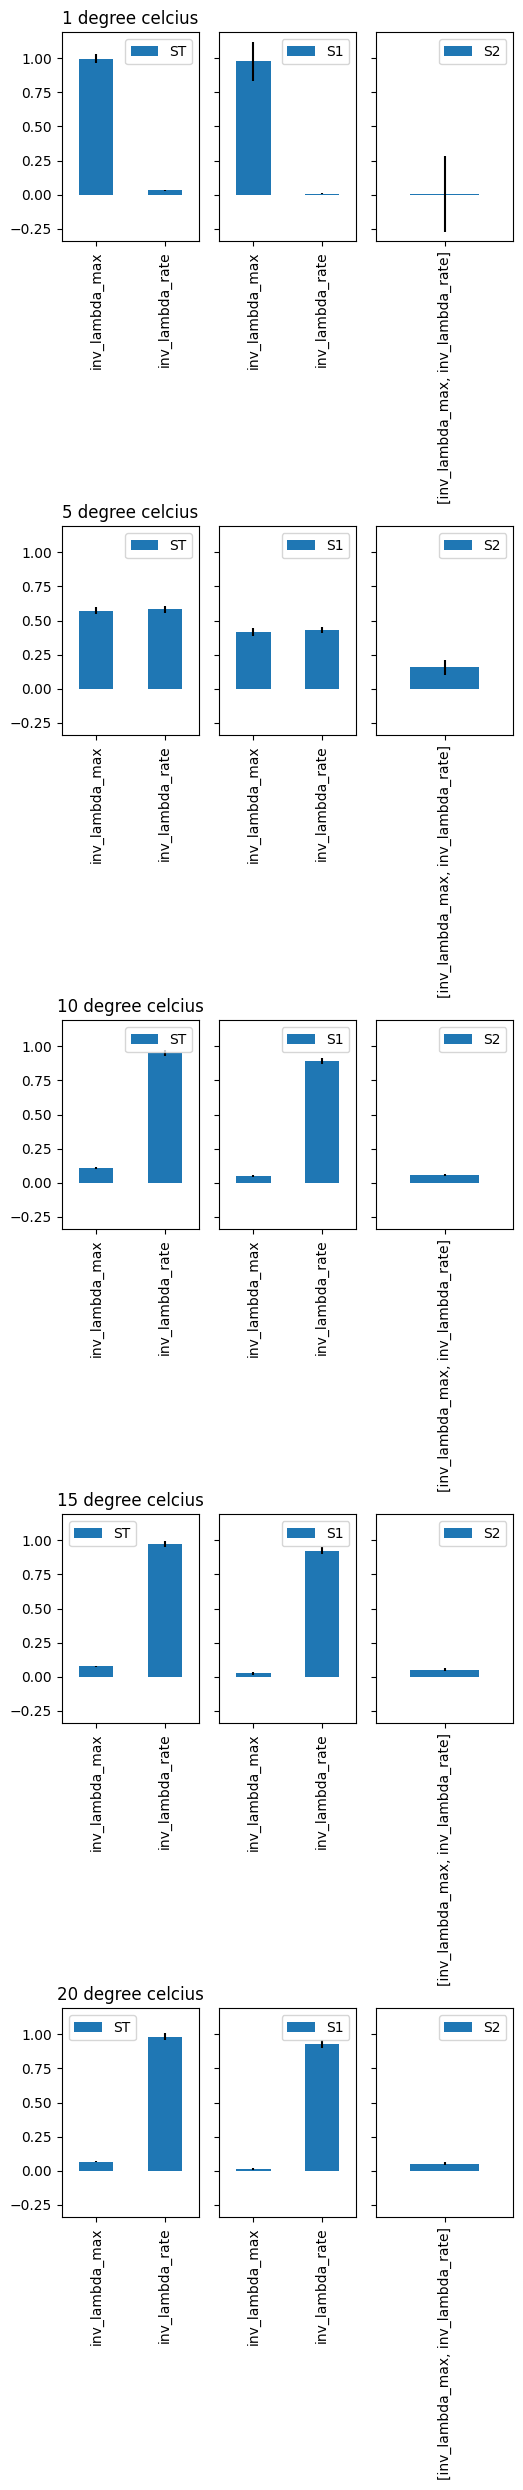

In [50]:
import matplotlib.pyplot as plt

axes = sp.plot()
fig = plt.gcf()  # get current figure
fig.set_size_inches(5, 25)
plt.tight_layout()